# Imports
<div style="width:100%;height:0;border-bottom: 3px solid #F59A31;margin-bottom: 1rem;"></div>


In [56]:
!pip install -Uq segmentation-models-pytorch

In [58]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from pathlib import Path
import cv2 as cv
from PIL import Image
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchmetrics.image import StructuralSimilarityIndexMeasure as SSIM
from torchmetrics.regression import MeanSquaredError as MSE
from torchmetrics.collections import MetricCollection
import gc
from torchvision.transforms import Normalize

# Import Monodepth2 components
from networks import ResnetEncoder, DepthDecoder

# Data & Visualization
### Note: brighter the area, farther it is in the image, brighter => more depth
<div style="width:100%;height:0;border-bottom: 3px solid #F7D735;margin-bottom: 1rem;"></div>


In [59]:
train_csv = Path('/home/mohammed/Downloads/data/nyu2_train.csv')
train_ims_path = Path('/home/mohammed/Downloads/data/nyu2_train')
base_path = Path('/home/mohammed/Downloads')

In [60]:
df = pd.read_csv(train_csv,header=None)
df[0] = df[0].map(lambda x:base_path/x)
df[1] = df[1].map(lambda x:base_path/x)
df.head()

,0,1
0,/home/mohammed/Downloads/data/nyu2_train/livin...,/home/mohammed/Downloads/data/nyu2_train/livin...
1,/home/mohammed/Downloads/data/nyu2_train/livin...,/home/mohammed/Downloads/data/nyu2_train/livin...
2,/home/mohammed/Downloads/data/nyu2_train/livin...,/home/mohammed/Downloads/data/nyu2_train/livin...
3,/home/mohammed/Downloads/data/nyu2_train/livin...,/home/mohammed/Downloads/data/nyu2_train/livin...
4,/home/mohammed/Downloads/data/nyu2_train/livin...,/home/mohammed/Downloads/data/nyu2_train/livin...


In [61]:
train_df, val_df = train_test_split(df,test_size=0.1,shuffle=True)
val_df, test_df = train_test_split(val_df, test_size=0.1,shuffle=True)
train_df.reset_index(drop=True,inplace=True)
val_df.reset_index(drop=True,inplace=True)
test_df.reset_index(drop=True,inplace=True)
train_df=train_df[0:10000]
val_df=val_df[0:1000]
len(train_df),len(val_df), len(test_df)

(10000, 1000, 507)

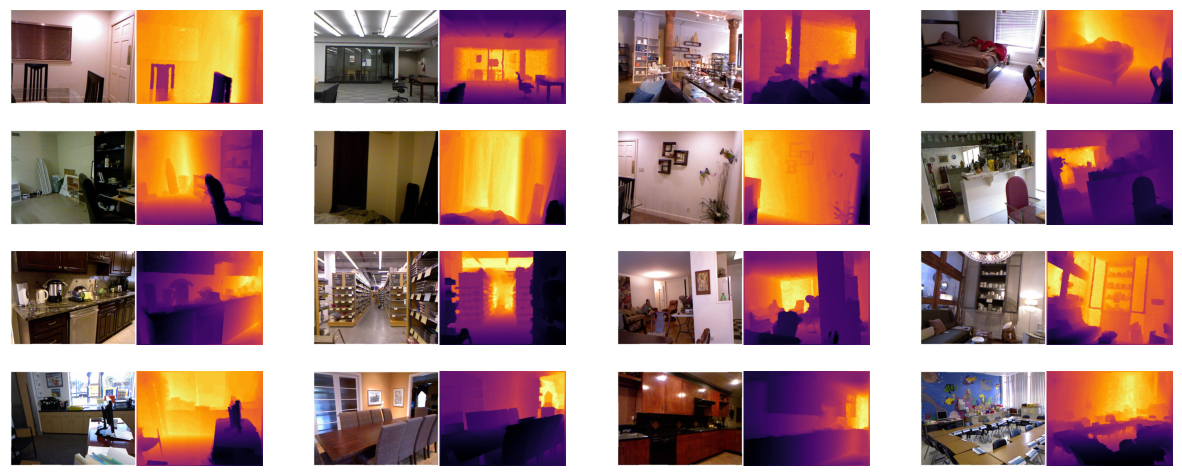

In [64]:
def colored_depthmap(depth, d_min=None, d_max=None,cmap=plt.cm.inferno):
    if d_min is None:
        d_min = np.min(depth)
    if d_max is None:
        d_max = np.max(depth)
    depth_relative = (depth - d_min) / (d_max - d_min)
    return 255 * cmap(depth_relative)[:,:,:3] # H, W, C

def merge_into_row(input, depth_target):
    input = np.array(input)
    depth_target = np.squeeze(np.array(depth_target))

    d_min = np.min(depth_target)
    d_max = np.max(depth_target)
    depth_target_col = colored_depthmap(depth_target, d_min, d_max)
    img_merge = np.hstack([input, depth_target_col])
    
    return img_merge




plt.figure(figsize=(15, 6))
for i, idx in enumerate(np.random.randint(0,len(df),(16,))):
    ax = plt.subplot(4, 4, i + 1)
    image = Image.open(df.iloc[idx,0]).convert('RGB')
    mask = Image.open(df.iloc[idx,1]).convert('L')
    image_viz = merge_into_row(
        image,mask
    )
    plt.imshow(image_viz.astype("uint8"))
    plt.axis("off")

# Dataset
<div style="width:100%;height:0;border-bottom: 3px solid #F7F437;margin-bottom: 1rem;"></div>


In [42]:
sample_tfms = [
    A.HorizontalFlip(),
    A.GaussNoise(p=0.2),
    A.OneOf([
        A.MotionBlur(p=.3),
        A.MedianBlur(blur_limit=3, p=0.3),
        A.Blur(blur_limit=3, p=0.5),
    ], p=0.3),
    A.RGBShift(),
    A.RandomBrightnessContrast(),
    A.RandomResizedCrop(384,384),
    A.ColorJitter(),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.3, rotate_limit=45, p=0.5),
    A.HueSaturationValue(p=0.3),
]
train_tfms = A.Compose([
    *sample_tfms,
    A.Resize(192, 640),
    A.Normalize(always_apply=True),
    ToTensorV2()
])
valid_tfms = A.Compose([
    A.Resize(192, 640),
    A.Normalize(always_apply=True),
    ToTensorV2()
])

In [43]:
class Dataset:
    def __init__(self,df,tfms):
        self.df = df
        self.tfms=tfms
    def open_im(self,p,gray=False):
        im = cv.imread(str(p))
        im = cv.cvtColor(im,cv.COLOR_BGR2GRAY if gray else cv.COLOR_BGR2RGB)
        return im
    
    def __len__(self,):
        return len(self.df)
    
    def __getitem__(self,idx):
        s = self.df.iloc[idx,:]
        im, dp = s[0],s[1]
        im, dp = self.open_im(im), self.open_im(dp,True)
        augs = self.tfms(image=im,mask=dp)
        im, dp = augs['image'], augs['mask'] / 255.
        return im, dp.unsqueeze(0)

In [44]:
train_ds = Dataset(train_df,train_tfms)
val_ds = Dataset(val_df,valid_tfms)
test_ds = Dataset(test_df, valid_tfms)
len(train_ds), len(val_ds), len(test_ds)

(10000, 1000, 507)

# Transforms Visualization
<div style="width:100%;height:0;border-bottom: 3px solid #DEF839;margin-bottom: 1rem;"></div>

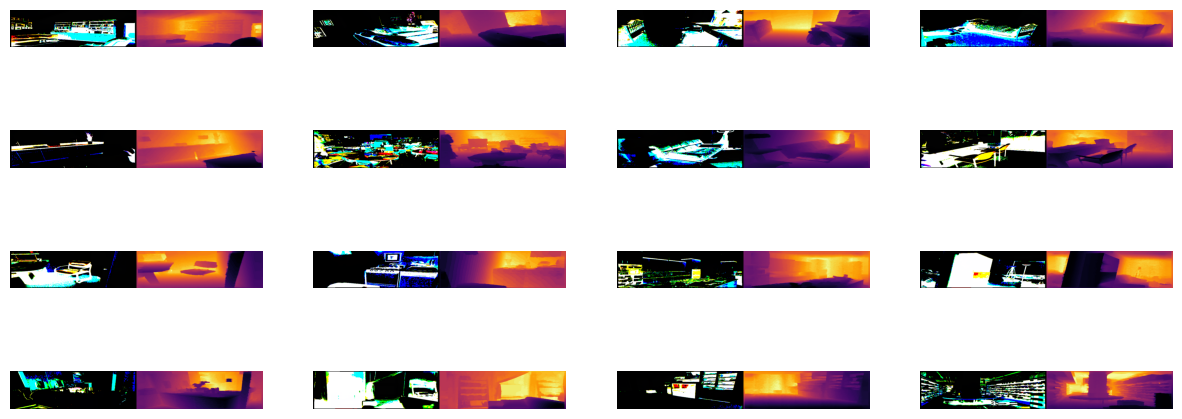

In [45]:
randoms = [test_ds[idx] for idx in range(16)]
plt.figure(figsize=(15, 6))
for i, (img,mask) in enumerate(randoms):
    ax = plt.subplot(4, 4, i + 1)
    img, mask = img.permute(1,2,0).numpy(), mask.permute(1,2,0).numpy()
    mask = colored_depthmap(np.squeeze(mask))
    image_viz = np.hstack([img,mask])
    plt.imshow(image_viz.astype("uint8"))
    plt.axis("off")

In [46]:
train_dl = torch.utils.data.DataLoader(train_ds,shuffle=True,batch_size=64)
val_dl = torch.utils.data.DataLoader(val_ds,shuffle=False,batch_size=64)
test_dl = torch.utils.data.DataLoader(test_ds, shuffle=True, batch_size=4)
len(train_dl), len(val_dl), len(test_dl)

(157, 16, 127)

# Model
<div style="width:100%;height:0;border-bottom: 3px solid #C3F93B;margin-bottom: 1rem;"></div>

In [47]:
class Monodepth2Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = ResnetEncoder(18, False)  # ResNet18 backbone
        self.decoder = DepthDecoder(self.encoder.num_ch_enc)
        
#     def trainable_encoder(self,trainable=True):
#         for p in self.model.encoder.parameters():
#             p.requires_grad = trainable

    def forward(self, x):
        features = self.encoder(x)
        outputs = self.decoder(features)
        return outputs[("disp", 0)]
        
#     def forward(self,x):
#         return self.model(x)
    
#     def _num_params(self,):
#         return sum([p.numel() for p in self.model.parameters() if p.requires_grad])

# Loss Function (Photometric Loss: L1 + SSIM)
# Loss Function (Photometric Loss: L1 + SSIM)
def photometric_loss(pred, target, device='cuda'):
    ssim_metric = SSIM(data_range=1.0).to(device)  # Ensure SSIM is on the correct device
    ssim_loss = (1 - ssim_metric(pred, target)) * 0.85
    l1_loss = nn.functional.l1_loss(pred, target)
    return ssim_loss + l1_loss


# Training
<div style="width:100%;height:0;border-bottom: 3px solid #F59A31;margin-bottom: 1rem;"></div>

### Metrics:

####  Structural Similarity Index (SSIM)

The structural similarity index (SSIM) is a perceptual metric that takes into account the structural similarity of the two images. SSIM is calculated by comparing the local patterns of the two images, taking into account the luminance, contrast, and structure of the images.

The formula for SSIM is:

$$ SSIM = \frac{(2 \mu_x \mu_y + c_1) (2 \sigma_{xy} + c_2)}{(\mu_x^2 + \mu_y^2 + c_1) (\sigma_x^2 + \sigma_y^2 + c_2)} $$

where μx​ and μy​ are the means of the two images, σx2​ and σy2​ are the variances of the two images, and σxy​ is the covariance of the two images. c1​ and c2​ are constants that are used to stabilize the calculation of SSIM.

SSIM is more robust to noise and small changes than MSE, but it is also more computationally expensive to calculate.

In general, SSIM is preferred over MSE for image quality assessment because it provides a more accurate measure of how humans perceive the similarity of two images. However, MSE is still a useful metric, especially when speed is important.

In [48]:
class UnNormalize(Normalize):
    def __init__(self,*args,**kwargs):
        mean=(0.485, 0.456, 0.406)
        std=(0.229, 0.224, 0.225)
        new_mean = [-m/s for m,s in zip(mean,std)]
        new_std = [1/s for s in std]
        super().__init__(new_mean, new_std, *args, **kwargs)

@torch.no_grad()
def plot_vals(imgs, preds, targets,n=4,figsize=(6,2),title=''):
    plt.figure(figsize=figsize,dpi=150)
    r = 2 if n == 4 else 8
    c = 2
    for i,idx in enumerate(np.random.randint(0,imgs.size(0),(n,))):
        ax = plt.subplot(r,c,i + 1)
        img,pred,gt = imgs[idx], preds[idx], targets[idx]
        img = UnNormalize()(img)*255.
        img,pred,gt = img.permute(1,2,0).numpy(), pred.permute(1,2,0).numpy(), gt.permute(1,2,0).numpy()
        pred = colored_depthmap(np.squeeze(pred))
        gt = colored_depthmap(np.squeeze(gt))
        image_viz = np.hstack([img,pred,gt])
        plt.imshow(image_viz.astype("uint8"))
        plt.axis("off")
    title = f'{title}\nimage/target/prediction' if len(title)!=0 else 'image/target/prediction'
    plt.suptitle(title)
    plt.show()

In [ ]:
epochs = 1
# freeze_epochs = 2
# lr = 1e-3

device = 'cuda'

metrics = MetricCollection([SSIM(data_range=(0, 1)).to(device), MSE().to(device)]).to(device)
train_metrics = metrics.clone().to(device)
val_metrics = metrics.clone().to(device)

logs = pd.DataFrame()
logs[['loss_train','loss_val','ssim_train','ssim_val','mse_train','mse_val']]=None

model = Monodepth2Model().to(device)
# model.trainable_encoder(trainable=False)

loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# optim = torch.optim.AdamW(model.parameters(),lr=lr / 25.,weight_decay=0.02)
# sched = torch.optim.lr_scheduler.OneCycleLR(optim,max_lr=lr,epochs=epochs,steps_per_epoch=(len(train_dl)))

scaler = GradScaler()

/home/mohammed/anaconda3/envs/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/mohammed/anaconda3/envs/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_118796/586802758.py:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [50]:
# Training and Validation Loop
logs = pd.DataFrame(columns=['loss_train', 'loss_val', 'ssim_train', 'ssim_val', 'mse_train', 'mse_val'])
best_ssim = -1e9
best_epoch = -1

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    train_metrics.reset()

    for img, depth_gt in tqdm(train_dl):
        img, depth_gt = img.to(device), depth_gt.to(device)
        optimizer.zero_grad()

        with autocast():
            depth_pred = model(img)
            loss = photometric_loss(depth_pred, depth_gt)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
        train_metrics(depth_pred, depth_gt)

    train_metric_values = train_metrics.compute()
    logs.loc[epoch, ['loss_train', 'ssim_train', 'mse_train']] = (
        running_loss / len(train_dl),
        train_metric_values['StructuralSimilarityIndexMeasure'].item(),
        train_metric_values['MeanSquaredError'].item()
    )

    # Validation Step
    model.eval()
    val_loss = 0.0
    val_metrics.reset()

    with torch.no_grad():
        for img, depth_gt in val_dl:
            img, depth_gt = img.to(device), depth_gt.to(device)
            depth_pred = model(img)
            val_loss += photometric_loss(depth_pred, depth_gt).item()
            val_metrics(depth_pred, depth_gt)

    val_metric_values = val_metrics.compute()
    logs.loc[epoch, ['loss_val', 'ssim_val', 'mse_val']] = (
        val_loss / len(val_dl),
        val_metric_values['StructuralSimilarityIndexMeasure'].item(),
        val_metric_values['MeanSquaredError'].item()
    )

    # Save best model based on SSIM
    if val_metric_values['StructuralSimilarityIndexMeasure'].item() > best_ssim:
        best_ssim = val_metric_values['StructuralSimilarityIndexMeasure'].item()
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_monodepth2_model.pt')

    print(f"Epoch {epoch + 1}/{epochs} - Training Loss: {running_loss / len(train_dl):.4f}, Validation Loss: {val_loss / len(val_dl):.4f}")
    print(f"SSIM Train: {train_metric_values['StructuralSimilarityIndexMeasure'].item():.4f}, SSIM Val: {val_metric_values['StructuralSimilarityIndexMeasure'].item():.4f}")


  0%|          | 0/157 [00:00<?, ?it/s]/tmp/ipykernel_118796/2318277816.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 157/157 [01:59<00:00,  1.31it/s]


Epoch 1/10 - Training Loss: 0.2383, Validation Loss: 0.2136
SSIM Train: 0.8529, SSIM Val: 0.8663


  0%|          | 0/157 [00:00<?, ?it/s]/tmp/ipykernel_118796/2318277816.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 157/157 [01:56<00:00,  1.35it/s]


Epoch 2/10 - Training Loss: 0.2185, Validation Loss: 0.1823
SSIM Train: 0.8646, SSIM Val: 0.8872


  0%|          | 0/157 [00:00<?, ?it/s]/tmp/ipykernel_118796/2318277816.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 157/157 [01:56<00:00,  1.35it/s]


Epoch 3/10 - Training Loss: 0.2135, Validation Loss: 0.1747
SSIM Train: 0.8672, SSIM Val: 0.8912


  0%|          | 0/157 [00:00<?, ?it/s]/tmp/ipykernel_118796/2318277816.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 157/157 [01:56<00:00,  1.35it/s]


Epoch 4/10 - Training Loss: 0.2101, Validation Loss: 0.1676
SSIM Train: 0.8690, SSIM Val: 0.8960


  0%|          | 0/157 [00:00<?, ?it/s]/tmp/ipykernel_118796/2318277816.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 157/157 [01:54<00:00,  1.37it/s]


Epoch 5/10 - Training Loss: 0.2051, Validation Loss: 0.1675
SSIM Train: 0.8721, SSIM Val: 0.8955


  0%|          | 0/157 [00:00<?, ?it/s]/tmp/ipykernel_118796/2318277816.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 157/157 [01:56<00:00,  1.35it/s]


Epoch 6/10 - Training Loss: 0.2030, Validation Loss: 0.1586
SSIM Train: 0.8733, SSIM Val: 0.9008


  0%|          | 0/157 [00:00<?, ?it/s]/tmp/ipykernel_118796/2318277816.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 157/157 [01:54<00:00,  1.37it/s]


Epoch 7/10 - Training Loss: 0.1997, Validation Loss: 0.1597
SSIM Train: 0.8752, SSIM Val: 0.9009


  0%|          | 0/157 [00:00<?, ?it/s]/tmp/ipykernel_118796/2318277816.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 157/157 [01:55<00:00,  1.36it/s]


Epoch 8/10 - Training Loss: 0.1979, Validation Loss: 0.1582
SSIM Train: 0.8761, SSIM Val: 0.9023


  0%|          | 0/157 [00:00<?, ?it/s]/tmp/ipykernel_118796/2318277816.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 157/157 [01:54<00:00,  1.38it/s]


Epoch 9/10 - Training Loss: 0.1958, Validation Loss: 0.1616
SSIM Train: 0.8774, SSIM Val: 0.8985


  0%|          | 0/157 [00:00<?, ?it/s]/tmp/ipykernel_118796/2318277816.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 157/157 [01:56<00:00,  1.35it/s]


Epoch 10/10 - Training Loss: 0.1918, Validation Loss: 0.1492
SSIM Train: 0.8794, SSIM Val: 0.9064


# Predictions
<div style="width:100%;height:0;border-bottom: 3px solid #F7D735;margin-bottom: 1rem;"></div>

In [51]:
best_epoch

9

# Results
<div style="width:100%;height:0;border-bottom: 3px solid #8DFA3F;margin-bottom: 1rem;"></div>

In [52]:
logs

,loss_train,loss_val,ssim_train,ssim_val,mse_train,mse_val
0,0.238273,0.213553,0.85288,0.866313,0.023684,0.017022
1,0.218532,0.182325,0.864578,0.887158,0.020234,0.014351
2,0.21348,0.174672,0.86719,0.891203,0.019158,0.01301
3,0.210056,0.167552,0.868979,0.895983,0.018327,0.012483
4,0.20512,0.167516,0.872133,0.895493,0.017491,0.011369
5,0.203004,0.158553,0.87333,0.900821,0.017185,0.010398
6,0.199737,0.159749,0.875211,0.900918,0.016825,0.01178
7,0.197856,0.158164,0.87608,0.902331,0.016325,0.011552
8,0.195764,0.161614,0.877389,0.898485,0.015886,0.010746
9,0.19183,0.149179,0.879359,0.906439,0.015186,0.009599


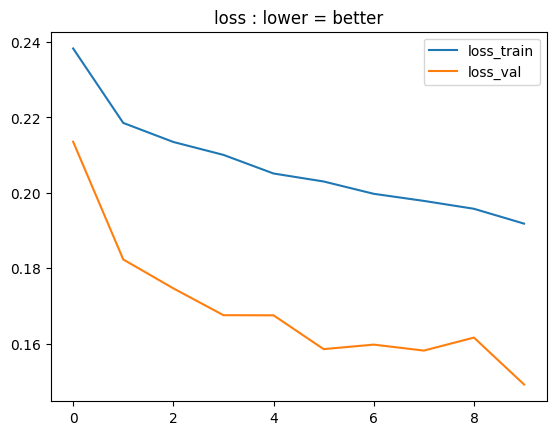

In [53]:
logs['loss_train'].plot()
logs['loss_val'].plot()
plt.title('loss : lower = better')
plt.legend()
plt.show()

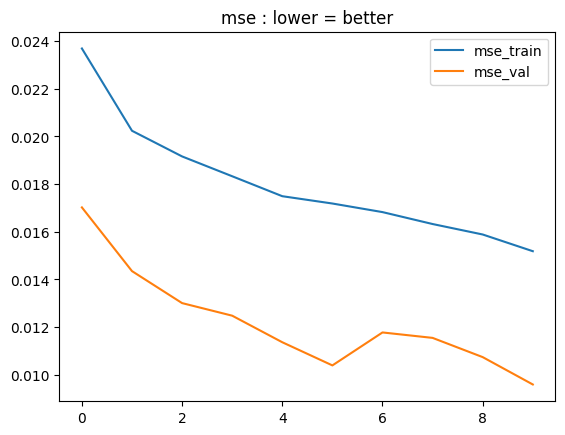

In [54]:
logs['mse_train'].plot()
logs['mse_val'].plot()
plt.title('mse : lower = better')
plt.legend()
plt.show()

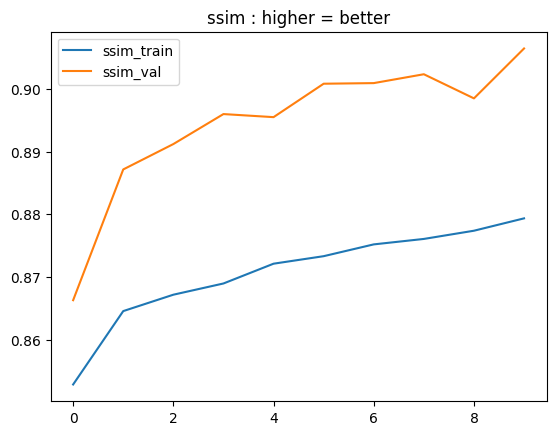

In [55]:
logs['ssim_train'].plot()
logs['ssim_val'].plot()
plt.title('ssim : higher = better')
plt.legend()
plt.show()